# AutoKeras implementation {-} 

This notebook uses Autokeras, an automated machine learning library built upon Tensorflow and Keras. The goal of AutoKeras is to make machine learning accessible for everyone.

This example takes a real-life dataset [dogs vs cat](https://www.kaggle.com/c/dogs-vs-cats/data) and tries to train a well working image classifier without a user who decides which layers to use.

Please make sure that your driver configuration is correct (using Nvidia CUDA and cuDNN) and that the library makes its calculations on a GPU. Note that this code is written for AutoKeras v1.0.2 and may be updated for future versions.

Thank you for reading and enjoy exploring AutoKeras!

Robbe Decorte

## Global imports and declarations {-}

In [ ]:
# Use this when running in the cloud or if the packages aren't already installed

!pip install autokeras
!pip install keras
!pip install tensorflow==2.1.0

In [1]:
import pandas as pd
import numpy as np
import autokeras as ak

MAX_TRIES=5
SIZE=64
OUTPUT_NAME="autokeras-model-5"

## Verify GPU status {-}

In [70]:
# Use the Keras GPU package
# conda install -c anaconda keras-gpu
from tensorflow.python.client import device_lib

In [71]:
# Show detailed information about the usable devices for Tensoflow
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7502211016056982511
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3142752665
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12990106037986299612
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [72]:
# Only request device names
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


## Shuffle data and convert to numpy array {-}

In [18]:
import os
from tqdm import tqdm
from PIL import Image
from random import shuffle

INPUT_PATH="data/train/"

In [20]:
def get_label(file):
    class_label = file.split('.')[0]
    if class_label == 'dog': label_vector = 0
    elif class_label == 'cat': label_vector = 1
    return label_vector

In [21]:
def get_data():
    data = []
    files = os.listdir(INPUT_PATH)
    for image in tqdm(files):
        
        label_vector = get_label(image)

        img = Image.open(INPUT_PATH + image).convert('L')
        img = img.resize((SIZE,SIZE))
        
        data.append([np.asarray(img),np.array(label_vector)])
        
    shuffle(data)
    return data

In [22]:
data = get_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:54<00:00, 217.91it/s]


In [23]:
# Save the data as a numpy array
np.save('data/images_shuffled.npy', data)

## Data preprocessing and split to test and train {-}

In [2]:
data = np.load('data/images_shuffled.npy', allow_pickle=True)

# Split the labled data in train (20000 images) and test (5000 images)
train = data[:20000]
test = data[20000:]

print("Training dataset contains %d items" % len(train))
print("Testing dataset contains %d items" % len(test))

Training dataset contains 20000 items
Testing dataset contains 5000 items


In [3]:
x_train = np.array([data[0] for data in train], 'float32')
x_test = np.array([data[0] for data in test], 'float32')
y_train = [data[1] for data in train]
y_test = [data[1] for data in test]

In [4]:
x_train = np.array(x_train).reshape(-1,SIZE,SIZE,1)
x_test = np.array(x_test).reshape(-1,SIZE,SIZE,1)

x_train /= 255
x_test /= 255

y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(20000, 64, 64, 1)
(20000,)
(5000, 64, 64, 1)
(5000,)


## Training and model evaluation {-}

In [ ]:
# Init image classifier.
clf = ak.ImageClassifier(max_trials=MAX_TRIES, name=OUTPUT_NAME)
# Feed the image classifier with training data.
clf.fit(x_train,y_train, verbose=2)

In [ ]:
# This is a temporary workaround for a bug in the eager search algorithms
# https://github.com/keras-team/autokeras/issues/1045

clf = ak.AutoModel(
    inputs=[ak.ImageInput()], 
    outputs=[ak.ClassificationHead()], 
    tuner="random", 
    max_trials=MAX_TRIES, 
    name=OUTPUT_NAME, 
    overwrite=False
)

clf.fit(x_train, y_train, verbose=2)

In [53]:
score = clf.evaluate(x_test, y_test)

157/157 [==============================] - ETA: 13s - loss: 0.6545 - accuracy: 0.718 - ETA: 5s - loss: 0.6889 - accuracy: 0.796 - ETA: 4s - loss: 0.5824 - accuracy: 0.81 - ETA: 3s - loss: 0.5444 - accuracy: 0.82 - ETA: 3s - loss: 0.6013 - accuracy: 0.82 - ETA: 3s - loss: 0.6256 - accuracy: 0.82 - ETA: 3s - loss: 0.6035 - accuracy: 0.82 - ETA: 2s - loss: 0.6514 - accuracy: 0.82 - ETA: 2s - loss: 0.6221 - accuracy: 0.83 - ETA: 2s - loss: 0.6244 - accuracy: 0.83 - ETA: 2s - loss: 0.6180 - accuracy: 0.82 - ETA: 2s - loss: 0.6278 - accuracy: 0.83 - ETA: 2s - loss: 0.6278 - accuracy: 0.83 - ETA: 2s - loss: 0.6330 - accuracy: 0.83 - ETA: 2s - loss: 0.6378 - accuracy: 0.83 - ETA: 2s - loss: 0.6155 - accuracy: 0.83 - ETA: 1s - loss: 0.6196 - accuracy: 0.83 - ETA: 1s - loss: 0.6450 - accuracy: 0.83 - ETA: 1s - loss: 0.6463 - accuracy: 0.83 - ETA: 1s - loss: 0.6567 - accuracy: 0.82 - ETA: 1s - loss: 0.6539 - accuracy: 0.82 - ETA: 1s - loss: 0.6547 - accuracy: 0.82 - ETA: 1s - loss: 0.6527 - accur

In [64]:
print('Accuracy: {accuracy}\nLoss: {loss}'.format(accuracy=score[1], loss=score[0]))

Accuracy: 0.8274000287055969
Loss: 0.6383044676065445


In [65]:
model = clf.export_model()
model.save(OUTPUT_NAME + '/model.h5')
print('Model succesfully exported')
print(type(model))

Model succesfully exported
<class 'tensorflow.python.keras.engine.training.Model'>


## Model visualization {-}

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
from tensorflow.python.keras.models import load_model
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score

In [6]:
# Load model
cust = ak.CUSTOM_OBJECTS
cust['Normalization'] = Normalization

model = load_model(OUTPUT_NAME+'/model.h5', custom_objects=cust)

print("Model succesfully loaded")

Model succesfully loaded


In [7]:
score = model.evaluate(x_test, y_test)

5000/5000 [==============================] - ETA: 7:47 - loss: 0.6545 - accuracy: 0.71 - ETA: 1:16 - loss: 0.6116 - accuracy: 0.82 - ETA: 37s - loss: 0.5888 - accuracy: 0.8255 - ETA: 25s - loss: 0.5969 - accuracy: 0.829 - ETA: 19s - loss: 0.6514 - accuracy: 0.822 - ETA: 15s - loss: 0.6259 - accuracy: 0.828 - ETA: 12s - loss: 0.6182 - accuracy: 0.830 - ETA: 10s - loss: 0.6281 - accuracy: 0.830 - ETA: 9s - loss: 0.6330 - accuracy: 0.833 - ETA: 8s - loss: 0.6382 - accuracy: 0.83 - ETA: 7s - loss: 0.6168 - accuracy: 0.83 - ETA: 6s - loss: 0.6506 - accuracy: 0.83 - ETA: 5s - loss: 0.6567 - accuracy: 0.82 - ETA: 4s - loss: 0.6495 - accuracy: 0.82 - ETA: 4s - loss: 0.6525 - accuracy: 0.82 - ETA: 3s - loss: 0.6561 - accuracy: 0.82 - ETA: 3s - loss: 0.6409 - accuracy: 0.83 - ETA: 2s - loss: 0.6329 - accuracy: 0.83 - ETA: 2s - loss: 0.6495 - accuracy: 0.82 - ETA: 2s - loss: 0.6381 - accuracy: 0.82 - ETA: 1s - loss: 0.6352 - accuracy: 0.83 - ETA: 1s - loss: 0.6492 - accuracy: 0.82 - ETA: 1s - los

In [8]:
print('Accuracy: {accuracy}\nLoss: {loss}'.format(accuracy=score[1], loss=score[0]))

Accuracy: 0.8274000287055969
Loss: 0.6383046453475952


In [9]:
predictions = model.predict(x_test)

Text(90.80000000000001, 0.5, 'predicted category')

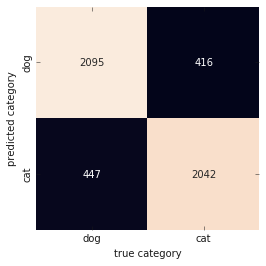

In [10]:
plt.style.use('classic')
%matplotlib inline

mat = confusion_matrix(y_test, predictions.round())
labels = ['dog', 'cat']

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('true category')
plt.ylabel('predicted category')

In [11]:
instances = 0
correct_ones = 0

images = x_test.reshape(5000,64, 64)
incorrect_predictions = []

for i in range(0, len(predictions)):
    if i < 5:
        print("Prediction: ", predictions[i], ", Actual: ", y_test[i])
    if predictions[i].round() == y_test[i]:
        correct_ones += 1
    else:
        incorrect_predictions.append((i, images[i], predictions[i].round(4), y_test[i]))
    instances += 1
    
print('\nMade {amountPred} predictions. {amountCorrect} of those are correct. Approximately {percentage}%.'
      .format(amountPred=instances, amountCorrect=correct_ones, percentage=round((correct_ones/instances) * 100)))

Prediction:  [0.5145127] , Actual:  0
Prediction:  [0.56603503] , Actual:  0
Prediction:  [0.99702567] , Actual:  0
Prediction:  [4.35466e-07] , Actual:  0
Prediction:  [0.98181605] , Actual:  1

Made 5000 predictions. 4137 of those are correct. Approximately 83%.


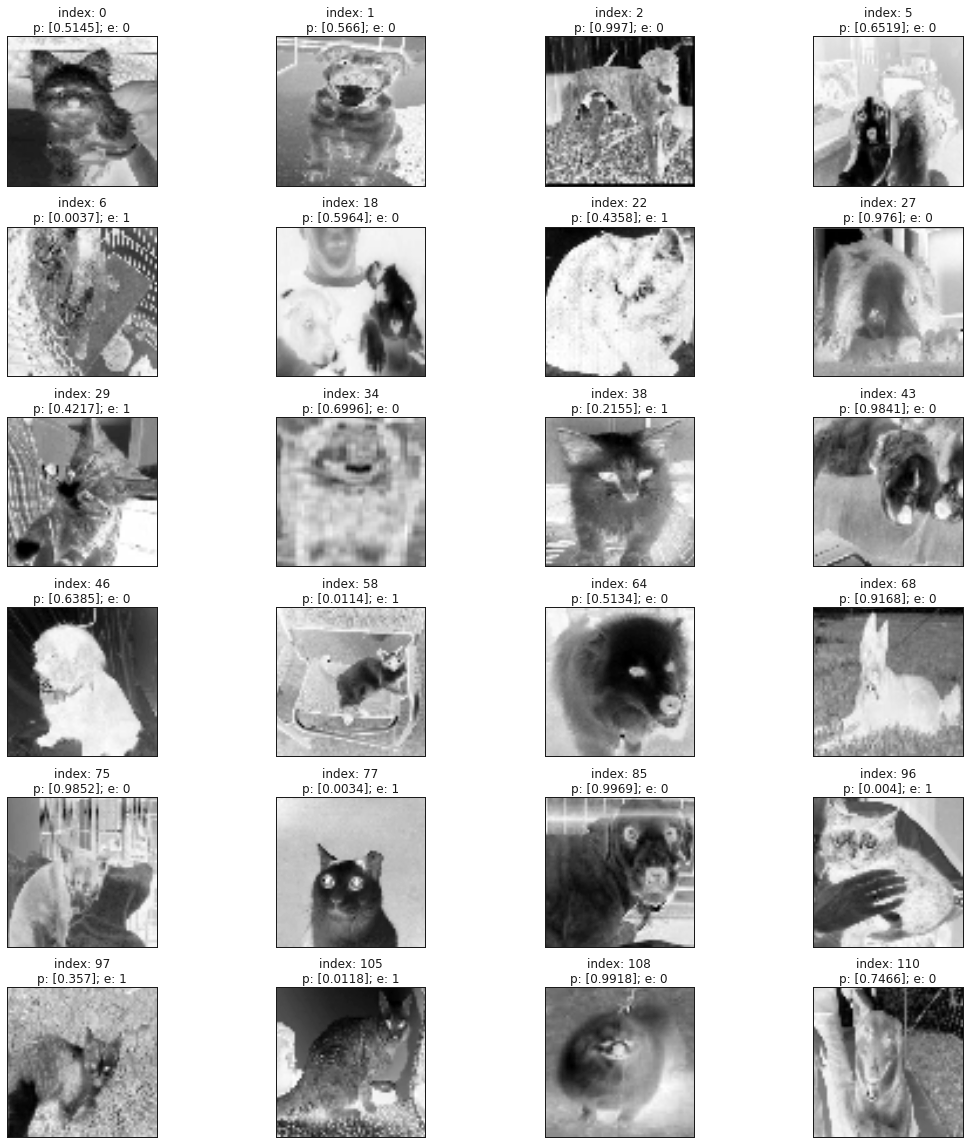

In [12]:
# Show images that are classified to the wrong class
# Dog = 0, Cat = 1
%matplotlib inline

figure, axes = plt.subplots(nrows=6, ncols=4, figsize=(16,16))

for axes, item in zip(axes.ravel(), incorrect_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(f'index: {index}\np: {predicted}; e: {expected}')
plt.tight_layout()

In [67]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
normalization (Normalization (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0     

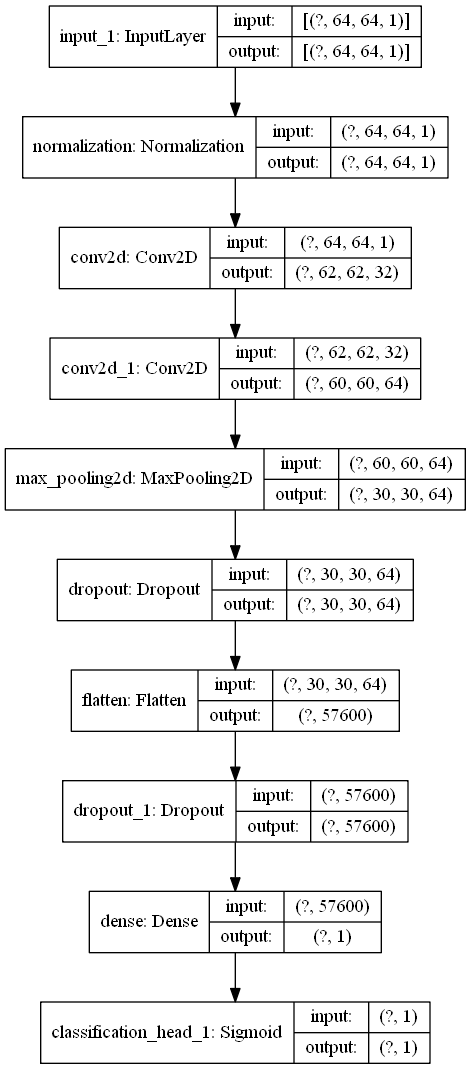

In [68]:
plot_model(model, to_file=OUTPUT_NAME + '/model.png', show_shapes=True, show_layer_names=True)